## (c) Complex Equity-CDS Market Interactions
    Group Member: Jiahang Li, Man He, Ruida Wu, Siqi Wang, Yilin Shi, Yudong Zhao

   [1. Data Preparation](#1)<br>
   [2. CDS Valuation Model Over Time](#2)<br>
   [3. CDS Pricing Errors Spillover to Stock Markets](#3)<br>

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

<a id='1'></a>
### 1. Data Preparation
    1. Stock price and cds spread data from Prof Lim.
    2. Fama French 5 Factors (Mktrf, SMB, HML, RMW, CMA) and Rf from Kenneth R. French Data Library.
    3. TERM: 10Year - 3Month Treasury rate
    4. DEF: US Corporate BBB Effective Yield - 10 Year Treasury Rate

Source Link:<br>
[Kenneth R.French Data Library](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)<br>
[FRB](https://www.federalreserve.gov/)<br>
[US Corporate BBB Bond Risk Premium](https://ycharts.com/indicators/us_corporate_bbb_bond_risk_premium)<br>


#### 1.1 A quick view of all Sample Data.

In [2]:
adr_all = './sampledata.dta'
data_all = pd.read_stata(adr_all)
data_all.permno = data_all.permno.astype(int)
data_all.date = data_all.date.astype(int)
data_all.year = data_all.year.astype(int)
data_all.month = data_all.month.astype(int)
data_all.tail(3)

,index,permno,date,year,month,stock_prc,mktrf,smb,hml,rf,...,TERM,DEF,mom,stock_volatility,market_leverage,Credit_A,Credit_B,Credit_C,rmw,cma
1730797,1833973,93150,20151229,2015,12,40.560001,1.05,0.09,-0.31,0.0,...,2.09,2.12,0.53,0.024101,0.0,0,0,1,0.03,-0.33
1730798,1833974,93150,20151230,2015,12,39.980000,-0.74,-0.17,-0.13,0.0,...,2.10,2.12,0.33,0.024342,0.0,0,0,1,0.04,0.15
1730799,1833975,93150,20151231,2015,12,39.700001,-0.92,-0.24,0.25,0.0,...,2.11,2.15,-0.36,0.026349,0.0,0,0,1,-0.12,0.10


#### 1.2 Part of Table 1 in Paper. (Number of CDS firms in each year)

In [3]:
samplefirms = data_all.groupby('year')
No_of_cds_firms = {}
for i in range(2001,2016):
    samplefirm = samplefirms.get_group(i)
    no_of_cds_firms = samplefirm.groupby('permno')
    No_of_cds_firms.update({i : len(no_of_cds_firms)})
No_of_cds_firms = pd.DataFrame.from_dict(No_of_cds_firms, columns = ['No. of CDS Firms'], orient='index')
No_of_cds_firms

,No. of CDS Firms
2001,228
2002,323
2003,421
2004,520
2005,588
2006,632
2007,657
2008,635
2009,604
2010,589


In [4]:
print('After merging the data, we got ', len(data_all), 'firm-day observations for', \
      len(data_all.permno.unique()), 'firms from', data_all.date.min(), 'to', data_all.date.max(), '.')

After merging the data, we got  1730800 firm-day observations for 866 firms from 20010214 to 20151231 .


<a id='2'></a>
### 2. CDS Valuation Model Over Time
    1. Data outlook
    2. Times series regression and cross-sectional regression.
    2. Price CDS and get CPE results.

#### 2.1 Data outlook

In [5]:
cdsdata = data_all[['permno', 'date', 'year','cds_spread']].copy()
cdsdata = cdsdata.set_index(['permno','date'])
cdsdata.head(3)

year  cds_spread
permno date                      
10078  20010830  2001    0.007995
       20010831  2001    0.008737
       20010904  2001    0.008737

In [6]:
stockdata = data_all[['permno', 'date', 'stock_prc']].copy()
stockdata = stockdata.set_index(['permno','date'])
stockdata.head(3)

stock_prc
permno date               
10078  20010830      11.07
       20010831      11.45
       20010904      10.95

In [7]:
cdsfactors = data_all[['permno', 'date', 'year', 'TERM', 'DEF', 'stock_volatility', 'market_leverage', 'Credit_A', \
                       'Credit_B', 'Credit_C']].copy()
cdsfactors = cdsfactors.set_index(['date'])
cdsfactors = cdsfactors.drop_duplicates()
cdsfactors.head(3)

,permno,year,TERM,DEF,stock_volatility,market_leverage,Credit_A,Credit_B,Credit_C
date,,,,,,,,,
20010830,10078,2001,1.43,1.98,0.051351,0.040125,0,1,0
20010831,10078,2001,1.48,2.01,0.046929,0.038845,0,1,0
20010904,10078,2001,1.55,2.02,0.045384,0.040546,0,1,0


In [8]:
#For convenience, I also put momentum factor into FF5fators dataframe.
FF5factors = data_all[['date', 'year', 'mktrf', 'smb', 'hml', 'rf', 'rmw', 'cma', 'mom']].copy()
FF5factors = FF5factors.set_index(['date'])
FF5factors = FF5factors[~FF5factors.index.duplicated(keep='first')]
FF5factors.head(3)

,year,mktrf,smb,hml,rf,rmw,cma,mom
date,,,,,,,,
20010830,2001,-1.60,0.32,0.63,0.013,0.67,1.21,1.16
20010831,2001,0.42,-0.38,0.29,0.013,-0.20,-0.22,-0.22
20010904,2001,-0.12,-0.39,0.65,0.018,1.02,0.42,0.55


In [9]:
# group all factors by year
TERMandDEF = cdsfactors[['year','TERM', 'DEF']].copy()
TERMandDEF = TERMandDEF[~TERMandDEF.index.duplicated(keep='first')]
cds5factor = cdsfactors[['permno', 'year', 'stock_volatility', 'market_leverage', 'Credit_A', \
                         'Credit_B', 'Credit_C']].copy()

TERMandDEF_groups = TERMandDEF.groupby('year') # do time series regression to get the factor exposure of this two
cds5factor_groups = cds5factor.groupby('year') # combine with the two exposure to do cross sectional regression

cds_groups = cdsdata.groupby('year') # cds spread of each year

In [10]:
# I use refer to create a cpe dataframe which has all date and permnos
refer = data_all[['permno', 'date', 'cds_spread']].copy()
refer = refer.set_index(['permno','date'])
refer = refer['cds_spread'].unstack(level=-1)

In [11]:
# group data by year
ff2factor = cdsfactors[['year','TERM', 'DEF']].copy()
ff2factor = ff2factor[~ff2factor.index.duplicated(keep='first')]
cds5factor = cdsfactors[['permno', 'year', 'stock_volatility', 'market_leverage', \
                         'Credit_A', 'Credit_B', 'Credit_C']].copy()

cds5groups = cds5factor.groupby('year')
ff2groups = ff2factor.groupby('year')
cgroups = cdsdata.groupby('year')

#### 2.2 Times series regression and cross-sectional regression.
1. The cds prices' **exposure** to the two variable **TERM** and **DEF** is estimated by do time series regression of the cds price on the two factors over some estimation period. **We use the previous 1 year here.**<br>
2. The resulting estimates of exposure(betas) were used as the independent variable in each day's cross-sectional regression of **next year**. We also added on the orginal 5 factors(**stock volatility, market leverage, CreditA, CreditB, CreditC**) in paper.
3. We used the cross-sectional regression result to get the predicted cds price as well as cds price error(**CPE**) of each day in this year. Also we calculate the $R^2$ of each day and average by year.
4. Step 1, Step 2 and Step 3 were then repeated for each year from 2001 to 2015 in the sample.

    _**Reference**: ChenRollRoss_JB_1986.pdf Page.394_

In [12]:
start_time = time.time()
cpes = pd.DataFrame(columns=refer.columns, index=refer.index)
loadings = pd.DataFrame()
#RSQUARE = {}
ARSQUARE = {}
for i in range(2001,2015):
    TERMandDEFgroup = TERMandDEF_groups.get_group(i).drop(columns=['year']) #factor group of year 2001
    prevcds_group = cds_groups.get_group(i).drop(columns=['year']) #cds group of year 2001

    currcds_group = cds_groups.get_group(i+1).drop(columns=['year']) #cds group of year 2002
    cds5factor_group = cds5factor_groups.get_group(i+1).drop(columns=['year']) #cds 5factors of year 2002

    reg1 = prevcds_group['cds_spread'].unstack(level=0).sort_index(axis=0)
    reg2 = currcds_group['cds_spread'].unstack(level=-1)
    
    #Step 1 Time Series regression
    N = len(reg1.columns) # get the number of firms
    beta = {}
    for j in range(N):
        y = reg1.iloc[:,j].to_frame().dropna()
        
        # to get the index of common days between two datasets
        comt = np.intersect1d(TERMandDEFgroup.index, y.index)
        
        x = TERMandDEFgroup.loc[comt,:]
        x = sm.add_constant(x)
        y = y.loc[comt]
        coefficient = pd.DataFrame(np.linalg.inv(x.T@x)@x.T@y)
        beta.update({y.columns[0] : coefficient.iloc[1:3,0].values}) #get beta of this firm for this year

    prevbetas = pd.DataFrame.from_dict(beta, orient='index') #here we got the factor exposure for firms for this year

    # Step 2 Cross-sectional regression
    # Use the exposures we got from step 1 and other 5 factors to do cross-sectional regression
    x = sm.add_constant(prevbetas)
    M = len(reg2.columns) #number of days that year
    #rsquareds = []
    Arsquareds = []
    for k in range(M):
        
        y = reg2.iloc[:,k].to_frame().dropna() #cds price of all firms on this day
        y.columns[0]
        x = sm.add_constant(prevbetas)
        xplus = cds5factor_group.loc[y.columns[0]].set_index('permno')
        
        # to get the index of common firms on this day
        comf1 = np.intersect1d(x.index, y.index)
        comf2 = np.intersect1d(x.index, xplus.index)
        comf = np.intersect1d(comf1,comf2)

        x = x.loc[comf,:]
        y = y.loc[comf,:]
        xplus = xplus.loc[comf,:]
        
        x = pd.concat([x,xplus], axis=1) #combine the beta loadings and original 5 factors of cds
        coefficient = pd.DataFrame(np.linalg.inv(x.T@x)@x.T@y)
        loadings = pd.concat([loadings,coefficient], axis=1)
        
        #Step 3 We predict the cds price of these firms, then calculate CPE and Rsquareds
        yhat = x.dot(coefficient.values)
        cpe = y.iloc[:,0]-yhat.iloc[:,0]
        cpes.loc[comf, y.columns[0]] = cpe

        #ESS = np.sum((yhat - np.average(y))**2)
        TSS = np.sum((y - np.average(y))**2)
        RSS = np.sum(cpe**2)
        n = len(y)
        #rsquared = (ESS.values/TSS.values)[0]
        Arsquared = 1 - (RSS/(n-7))/(TSS.values[0]/(n-1))
        
        #rsquareds.append(rsquared)
        Arsquareds.append(Arsquared)

    #RSQUARE.update({i+1 : np.mean(rsquareds)})
    ARSQUARE.update({i+1 : np.mean(Arsquareds)})
#RSQUARES = pd.DataFrame.from_dict(RSQUARE, columns = ['Rsquared'], orient='index')
ARSQUARES = pd.DataFrame.from_dict(ARSQUARE, columns = ['Adjusted_Rsquared'], orient='index')
print("--- %s seconds ---" % (time.time() - start_time))

--- 84.00251412391663 seconds ---


In [13]:
print(ARSQUARES.mean())
ARSQUARES

Adjusted_Rsquared    0.606005
dtype: float64


,Adjusted_Rsquared
2002,0.606590
2003,0.480977
2004,0.487281
2005,0.918323
2006,0.537255
2007,0.450292
2008,0.631879
2009,0.670218
2010,0.560263
2011,0.514918


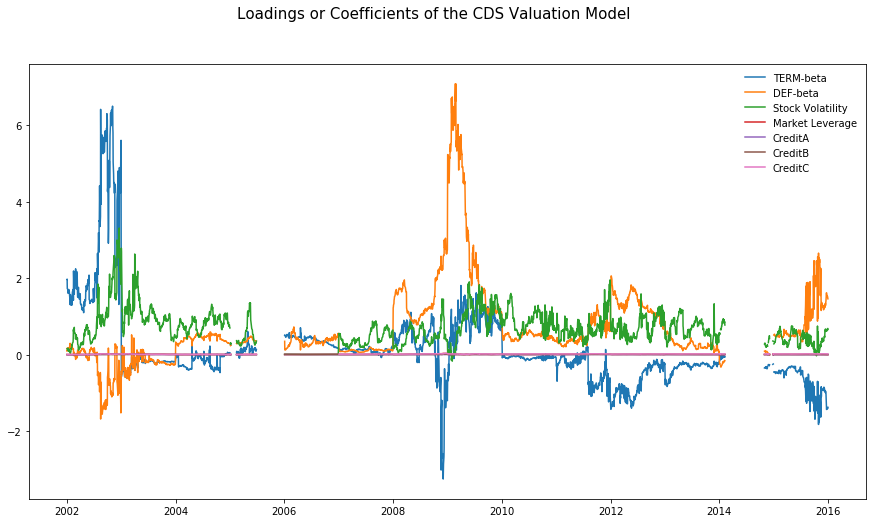

In [14]:
#Figure 2 in papaer
Loadings = loadings.copy().T
Loadings['date']=pd.to_datetime(Loadings.index, format='%Y%m%d')
fig, ax = plt.subplots(1, figsize=(15, 8))
x = Loadings['date']
fig.suptitle('Loadings or Coefficients of the CDS Valuation Model', fontsize=15)
ax.plot(x, Loadings[1], label="TERM-beta")
ax.plot(x, Loadings[2], label="DEF-beta")
ax.plot(x, Loadings[3], label="Stock Volatility")
ax.plot(x, Loadings[4], label="Market Leverage")
ax.plot(x, Loadings[5], label="CreditA")
ax.plot(x, Loadings[6], label="CreditB")
ax.plot(x, Loadings[7], label="CreditC")
plt.legend(loc="upper right", frameon=False)
plt.show()

1. The average **Adjusted R-square** of CDS valuation model is about **51%**.
2. However, we The pricing power of the CDS valuation model does not exhibit an increasing trend as the original paper.
3. There's no R-square for 2001, because we use the previous year to get the factor exposure for next year.

<a id='3'></a>
### 3. CDS Pricing Erros Spillover to Stock Markets
   Hypothesis 1: Increasing (decreasing) $CPE_{t-1}$ will on average lead increases (decreases) in stock prices.
   
   [LongShortStrategy](#4)<br>

#### 3.1 Function used

In [15]:
from itertools import chain
import random

# For each day, group the fims into 10 deciles.
def todecile(N):
    num = range(10)
    d = []
    n = N//10
    a = N%10
    rand = random.sample(num, a)
    for i in num:
        if i in rand:
            d.append([i+1]*(n+1))
        else:
            d.append([i+1]*n)
    d = list(chain(*d))
    return d
   
# Within each decile, we long stock with positive CPE and short stock with negative CPE.
def getlongshort(cpe):
    res = []
    for i in range(len(cpe)):
        if cpe.iloc[i,0] > 0:
            res.append(1)
        else:
            res.append(-1)
    return res


def mergedata(N,last,current,cpe):
    obs = last.copy()
    obs[current.columns[0]] = current
    obs['return'] = obs[current.columns[0]]/obs[last.columns[0]]-1
    obs['cpe'] = cpe
    obs['longorshort'] = getlongshort(cpe)
    obs = obs.sort_values(by = 'cpe')
    obs['decile'] = todecile(N)
    return obs

#late can merge all these into class

def getavgcpe(groups):
    res = []
    for i in range(10):
        group = groups.get_group(i+1)
        res.append(group['cpe'].mean())
    return res
 
def getfirmnum(groups):
    res = []
    for i in range(10):
        group = groups.get_group(i+1)
        res.append(len(group))
    return res
    
def getrawreturn(groups):
    res = []
    for i in range(10):
        group = groups.get_group(i+1)
        rawr = np.average(group['return']*group['longorshort'])*100
        res.append(rawr)
    return res 

<a id='4'></a>
#### 3.2 Implement the strategy
1. For each day t, we sort stocks in **acending order** by ten decile groups based on the constructed **CPE**.
2. Within each decile, we **long stock with positive CPE** and **short stock with negative CPE**.
3. We track the **equal-weighted portfolio** returns for each decile at day t+1.

In [17]:
start_time = time.time()

# prepare the CPE dataset and Stock price dataset
obcpe = cpes.copy()
obdate = cpes.columns.values
stockprc = stockdata['stock_prc'].unstack(level=-1)

# create empty dataframe for CPE, Number of Firms and Raw Retrun for all deciles
decilecpe = pd.DataFrame(index=range(1,11))
decilenf = pd.DataFrame(index=range(1,11))
decilerawreturn = pd.DataFrame(index=range(1,11))

#We observe the CDS pricing error on t，and check the portfolio return on t+1
T = len(obdate)
for i in range(T-1): 
    last = stockprc.iloc[:,i].to_frame().dropna() #last date stock price
    cpe = obcpe.iloc[:,i].to_frame().dropna() #last date CDS pricing error
    current = stockprc.iloc[:,i+1].to_frame().dropna() #current date stock price
    
    #find the common Firm index between last day and current day
    comf = np.intersect1d(last.index, current.index)
    comg = np.intersect1d(last.index, cpe.index)
    com = np.intersect1d(comf, comg)
    
    # N is the final number of considered Firms
    N = len(com)
    if N >= 220:
        lastdate = last.columns[0]
        currentdate = current.columns[0]
        
        last = last.loc[com,:]
        current = current.loc[com,:]
        cpe = cpe.loc[com,:]
        
        # we combine the stock data and cpe data
        # also we add a new column which contains +1 and -1
        # +1 means the cpe on last day is positive and vice versa
        obs = mergedata(N,last,current,cpe)
        obsgroups = obs.groupby(obs['decile'])
        
        decilecpe[currentdate] = getavgcpe(obsgroups)
        decilenf[currentdate] = getfirmnum(obsgroups)
        decilerawreturn[currentdate] = getrawreturn(obsgroups)

print("--- %s seconds ---" % (time.time() - start_time))

--- 86.09427118301392 seconds ---


In [18]:
print('An example for 20151230:')
print('-----------------------------------')
print('Step1: For each day t, we sort stocks in acending order by ten decile groups based on the constructed CPE.')
print(obs)
print('-----------------------------------')
print('Step2: Within each decile, we long stock with positive CPE and short stock with negative CPE.')
print('Outlook of decile 6 on the last day')
decile6 = obsgroups.get_group(6)
print(decile6.head(3))
print(decile6.tail(3))
print('-----------------------------------')
print('Step3: We track the equal-weighted portfolio returns for each decile at day t+1.')

An example for 20151230:
-----------------------------------
Step1: For each day t, we sort stocks in acending order by ten decile groups based on the constructed CPE.
         20151230   20151231    return        cpe  longorshort  decile
permno                                                                
87604    1.860000   1.610000 -0.134409  -0.059312           -1       1
38156   24.410000  25.700001  0.052847 -0.0523073           -1       1
77157   17.520000  17.420000 -0.005708 -0.0434812           -1       1
29102    8.300000   8.510000  0.025301 -0.0433883           -1       1
82298   20.850000  21.100000  0.011990 -0.0342107           -1       1
...           ...        ...       ...        ...          ...     ...
22517   34.340000  34.130001 -0.006115  0.0820481            1      10
89757   20.290001  20.559999  0.013307  0.0969538            1      10
91321    3.810000   3.860000  0.013123  0.0987688            1      10
65285    1.860000   1.810000 -0.026882   0.113267  

In [19]:
# raw return for each day and each decile 
decilerawreturn

,20030103,20030106,20030107,20030108,20030109,20030110,20030113,20030114,20030115,20030116,...,20151217,20151218,20151221,20151222,20151223,20151224,20151228,20151229,20151230,20151231
1,0.079601,-1.358267,1.312820,2.290984,-2.508211,-0.443382,-0.286843,-0.508832,0.670038,-0.710160,...,2.651508,1.985956,-0.549181,-1.948928,-3.229406,0.133009,1.306177,-2.143383,1.723388,0.451898
2,-0.887082,-1.484580,1.680191,1.131463,-2.066124,-0.136945,0.226138,-0.778779,1.222921,-0.515711,...,2.019797,1.372407,-0.608291,-1.368683,-2.866678,0.137994,1.283053,-1.045272,1.075136,0.249772
3,0.808754,-1.745387,1.549909,0.849672,-1.282607,-0.167045,0.203146,-0.197259,0.881700,-0.874384,...,1.859903,1.268303,-0.942971,-1.359185,-1.853255,0.263000,0.476345,-0.828851,1.054326,0.576886
4,0.174934,-2.043354,0.494560,1.003293,-2.201115,0.303180,0.044265,0.343235,0.456130,-0.290872,...,1.504014,1.214864,-0.856369,-0.452204,-1.964211,1.192064,0.210767,-1.010931,0.766474,0.783830
5,0.684321,-1.703708,1.492535,0.789639,-1.340857,-0.034618,0.293063,0.086993,1.512376,0.073313,...,1.711312,1.476008,-0.988393,-1.156439,-1.632765,0.165213,0.585343,-0.951003,0.884932,1.090154
6,0.281251,1.908866,-0.283858,-0.124011,-1.163256,-0.534733,0.218461,-0.700025,0.708436,-0.385470,...,0.761658,1.099589,-0.268864,-0.311605,-0.321823,0.068616,0.562183,-0.632264,0.765027,0.428886
7,-0.428067,1.902468,-0.355633,-0.979461,1.757880,-0.027387,-0.075580,-0.161665,-0.117608,-0.003346,...,-1.627564,-1.446400,0.495864,1.028309,1.546454,-0.059311,-0.082728,0.941954,-0.474647,-0.998808
8,-0.277275,1.869678,-0.860247,-1.176449,1.114053,-0.037957,-0.596810,0.597022,-0.536977,-0.003615,...,-1.407173,-1.346187,0.620405,0.999646,1.495834,-0.074963,-0.060451,0.860902,-0.693448,-0.935978
9,-0.231872,1.854333,-0.886691,-0.127741,1.237464,-0.037224,-0.339029,0.570024,-0.143697,-0.039440,...,-1.267758,-1.263391,0.821916,1.085630,1.729743,0.020740,-0.620266,0.802178,-0.649694,-0.991577
10,0.373275,1.716765,-0.315131,-0.507507,2.301091,0.327330,0.517069,1.005419,-0.904992,-0.662652,...,-1.995526,-0.162920,0.994017,1.651857,3.541171,0.552305,-1.709902,1.018300,-1.616162,-0.064026


#### 3.3 Outlook of Each CPE Decile
    1. Average CPE
    2. Average Number of Firms
    3. Average Raw Return and t-stats
    4. CAPM Alpha and t-stats
    5. Fama French 5 factors Alpha and t-stats
    6. Fama French 5 factors + momentun factor Alpha and t-stats 

In [20]:
# To get 1-3
CPEavg = decilecpe.mean(axis=1)
Nfirms = decilenf.mean(axis=1)
Rawavg = decilerawreturn.mean(axis=1)
Rawtstat = decilerawreturn.mean(axis=1)/np.sqrt(decilerawreturn.var(axis=1)/len(decilerawreturn.columns))

In [21]:
# To get 4-6
start_time = time.time()

capmalphas = []
capmtstats = []
ff5alphas = []
ff5tstats = []
ff5malphas = []
ff5mtstats = []

# We calculate each alpha decile by decile
for i in range(10):
    # Step 1. Combine Raw return with all factors
    Rt = decilerawreturn.loc[i+1,:]
    index = Rt.index
    Rt = pd.DataFrame(Rt.values, columns=['Rt'], index=index)
    factors = FF5factors.loc[index,:]
    df = pd.concat([Rt,factors], axis=1)
    df['Rtf'] = df['Rt'] -df['rf']/365 #Calculate excess return
    
    #CAPM
    mod1 = smf.ols('Rtf ~ 1 + mktrf', data=df).fit()
    capmalphas.append(mod1.params[0])
    capmtstats.append(mod1.tvalues[0])
    
    #Fama French 5 Factors
    mod2 = smf.ols('Rtf ~ 1 + mktrf + smb + hml + rmw + cma', \
                   data=df).fit(cov_type='HAC',cov_kwds={'maxlags':12})
    ff5alphas.append(mod2.params[0])
    ff5tstats.append(mod2.tvalues[0])
    
    #Fama French 5 factors and momentun factor
    mod3 = smf.ols('Rtf ~ 1 + mktrf + smb + hml + rmw + cma + mom', \
                   data=df).fit(cov_type='HAC',cov_kwds={'maxlags':12})
    ff5malphas.append(mod3.params[0])
    ff5mtstats.append(mod3.tvalues[0])

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.4240570068359375 seconds ---


In [22]:
res = pd.DataFrame(zip(CPEavg, Nfirms, Rawavg, Rawtstat, capmalphas, capmtstats, ff5alphas, ff5tstats, \
                       ff5malphas, ff5mtstats), \
                   columns=['CPE','Nfirms','RawRet','Rawtstat','CAPMalpha','CAPMtstat','FF5alpha','FF5tstat',\
                           'FF5malpha','FF5tmstat'], \
                   index=decilerawreturn.index)

#### Table 5A. CDS Pricing Errors Spillover to Stock Markets.
    The following table reports the results of an equal-weighted CDS pricing error(CPE) spillover strategy.

In [23]:
res

,CPE,Nfirms,RawRet,Rawtstat,CAPMalpha,CAPMtstat,FF5alpha,FF5tstat,FF5malpha,FF5tmstat
1,-0.019474,48.187028,-0.062823,-1.553136,-0.010553,-0.499113,-0.012481,-0.613124,-0.017337,-0.876496
2,-0.009401,48.186685,-0.025218,-0.789427,0.020678,2.034005,0.021034,2.236781,0.018340,1.984274
3,-0.005838,48.192862,-0.028590,-0.983809,0.013616,1.640411,0.015330,2.004004,0.014046,1.818535
4,-0.003639,48.180508,-0.043079,-1.585849,-0.003289,-0.472216,-0.002253,-0.305981,-0.004301,-0.598256
5,-0.001881,48.189087,-0.034466,-1.366600,0.002602,0.423601,0.004611,0.765453,0.002864,0.506320
6,-0.000307,48.186342,-0.002064,-0.136615,0.010408,0.821472,0.014253,1.143500,0.016515,1.299083
7,0.001255,48.187371,0.055024,2.429251,0.023446,2.628549,0.021491,2.479674,0.023175,2.622728
8,0.003180,48.183253,0.047712,2.073066,0.015098,1.840807,0.013504,1.621691,0.014397,1.769707
9,0.006857,48.170899,0.062705,2.468784,0.028097,2.518825,0.027107,2.455701,0.028554,2.524777
10,0.029015,48.168840,0.078305,2.087298,0.030433,1.500974,0.033054,1.783056,0.038808,2.201137


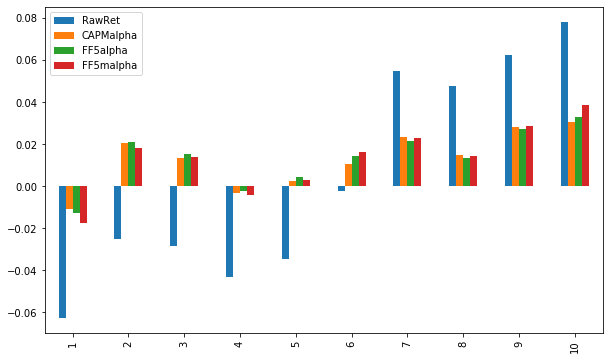

RawRet       0.004751
CAPMalpha    0.013054
FF5alpha     0.013565
FF5malpha    0.013506
dtype: float64


In [24]:
valueList = ['RawRet','CAPMalpha','FF5alpha','FF5malpha']
df = res.loc[:,valueList]
ax = df.plot.bar(figsize=(10,6))
plt.show()
print(df.mean())